# GEOCLIM Parameter Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm_notebook

from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

from scipy import stats
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## Functions

In [2]:
def extract_basin_variables(param_nc):
    """
    Get data for each basin in the basin mask.
    
    Parameters
    ----------
    param_nc : netCDF dataset
        netCDF output from the parameter exploration routine.
    
    Returns
    -------
    basin_model_df : dataframe
        Contains the t(CaMgNaK)/yr/km2 for each basin.
        
    total_CO2_consumption : array
        Total CO2 consumption (mol/yr) for each run.
        
    WSI : array
        weathering saturation index for each run.
    """
    n_runs = len(param_nc.variables['parameterization'])
    n_basins = len(basin_data['basin'])
    
    # get area map - units: m2
    area_map = param_nc.variables['area'][:,:].data.copy()
    area_map[np.isnan(area_map)] = 0
    area_map[area_map > 1e30] = 0
    
    # get lith map
    lith_map = param_nc.variables['litho_mask'][:,:]
    
    # get erosion map
    eros_map = param_nc.variables['erosion'][:,:].data.copy()
    eros_map[np.isnan(eros_map)] = 0
    eros_map[eros_map > 1e30] = 0
    
    # total erosion
    Etot = np.nansum(area_map * eros_map)
    
    # storage arrays
    basin_model = np.zeros((n_runs, n_basins))
    total_CO2_consumption = np.zeros(n_runs)
    WSI = np.zeros(n_runs)
    
    # loop over each parameter run
    for i in tqdm_notebook(range(n_runs), desc='run loop'):
        
        # get CO2 consumption map - units: mol(CaMg)/m2/yr
        CaMg_map = param_nc.variables['weathering'][i,:,:].data.copy()
        CaMg_map[np.isnan(CaMg_map)] = 0
        CaMg_map[CaMg_map > 1e30] = 0
        
        # convert CO2 consumption map from mol(CaMg)/m2/yr to mol(CaMg)/yr
        CaMg_map = CaMg_map * area_map
        
        # get total CO2 consumption
        total_CO2_consumption[i] = np.nansum(CaMg_map)
        
        # Weathering Saturation Index (WSI)
        lith_comp = param_nc.variables['CaMg'][i,:]
        CaMg_bedrock_map = lith_comp[lith_map-1]            
        WSI[i] = np.ma.sum( CaMg_map/CaMg_bedrock_map ) / Etot
        
        # loop over each basin
        for j in range(n_basins):
            
            # pull out the basin mask
            this_basin_mask = basin_mask.variables[basin_data['basin'][j]][:,:].data.copy()

            # convert NaNs to zeros
            this_basin_mask[np.isnan(this_basin_mask)] = 0

            # get rid of fill values
            this_basin_mask[this_basin_mask > 1e35] = 0

            # convert remaining values (the basin mask) to 1
            this_basin_mask[this_basin_mask != 0] = 1
            
            # change CO2 consumption and area to 0 everywhere that isn't in the basin
            this_basin_CaMg_map = CaMg_map.copy()
            this_basin_CaMg_map[this_basin_mask!=1] = 0
            this_basin_area_map = area_map.copy()
            this_basin_area_map[this_basin_mask!=1] = 0

            # sum and store - mol(CaMg)/yr/m2
            basin_model[i, j] = np.nansum(this_basin_CaMg_map) / np.nansum(this_basin_area_map)
            
    # store as a dataframe        
    basin_model_df = pd.DataFrame(columns=basin_data['basin'], data=basin_model)
    
    # convert from mol(CaMg)/yr/m2 to t(CaMgNaK)/yr/km2
    for i in range(n_basins):
        Gaillardet1999a_row = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']==basin_names[i]]
        if len(Gaillardet1999a_row.index)!=0:
            mol_kg = Gaillardet1999a_row['silicates_Ca+Mg_sil'].values[0]/\
                     Gaillardet1999a_row['silicates_Cation_sil'].values[0]
        else:
            mol_kg = 12.5
        basin_model_df[basin_data['basin'][i]] = ((basin_model_df[basin_data['basin'][i]]/mol_kg)/1000)*1e6
    
    return basin_model_df, total_CO2_consumption, WSI

In [3]:
def get_regression_coefficient(data, model):
    """
    Calculate the regression coefficient, as in Maffre et al. (2018) Appendix C.
    
    Parameters
    ----------
    data : array
        data values
        
    model : array
        model values
    
    Returns
    -------
    r2s : array
        regression coefficient
    """
    # convert to log
    model = np.log10(model.astype(np.float64))
    data = np.log10(data.astype(np.float64))
    
    # storage array
    r2s = np.zeros(np.shape(model)[0])
    
    for i in range(len(r2s)):
    
        # calculate the fraction
        numerator = np.sum((model[i,:] - data)**2)
        denominator = np.sum((data - np.mean(data))**2)
        
        # output r2
        r2s[i] = 1 - numerator/denominator
    
    return r2s

In [4]:
def get_params(param_nc):
    """
    Get the parameters out of the netCDF and into a pandas dataframe.
    
    Parameters
    ----------
    param_nc : netCDF dataset
        netCDF output from the parameter exploration routine.
        
    Returns
    -------
    params : dataframe
        parameters extracted from the netCDF output.
    """
    
    params_cols = ['Ea_rp',
                   'T0_rp',
                   'Ea',
                   'T0',
                   'krp',
                   'h0',
                   'ke',
                   'a',
                   'b',
                   'Kwest',
                   'kw',
                   'sigma']
    
    params = pd.DataFrame(columns=params_cols)
    
    for i in range(len(params_cols)):
        col_vals = param_nc.variables[params_cols[i]][:].data
        params[params_cols[i]] = col_vals
        
    params['CaMg_1'] = param_nc.variables['CaMg'][:,0].data
    params['CaMg_2'] = param_nc.variables['CaMg'][:,1].data
    params['CaMg_3'] = param_nc.variables['CaMg'][:,2].data
    params['CaMg_4'] = param_nc.variables['CaMg'][:,3].data
    params['CaMg_5'] = param_nc.variables['CaMg'][:,4].data
    params['CaMg_6'] = param_nc.variables['CaMg'][:,5].data
    
    params['litho_kin_factor_1'] = param_nc.variables['litho_kin_factor'][:,0].data
    params['litho_kin_factor_2'] = param_nc.variables['litho_kin_factor'][:,1].data
    params['litho_kin_factor_3'] = param_nc.variables['litho_kin_factor'][:,2].data
    params['litho_kin_factor_4'] = param_nc.variables['litho_kin_factor'][:,3].data
    params['litho_kin_factor_5'] = param_nc.variables['litho_kin_factor'][:,4].data
    params['litho_kin_factor_6'] = param_nc.variables['litho_kin_factor'][:,5].data
    
    return params

In [5]:
def triple_scatter(X, Y, Z, X_label, Y_label, Z_label, **kwargs):
    """
    Create a scatter plot where the data points are colored by a third variable.
    
    Parameters
    ----------
    X : array-like
        Data for the x-axis.
        
    Y : array-like
        Data for the y-axis.
        
    Z : array-like
        Data for the color.
        
    X_label : string
        Label for the x-axis.
    
    Y_label : string
        Label for the y-axis.
        
    Z_label : string
        Label for the colorbar.
        
    kwargs : keyword arguments
        Passed to plt.scatter.
    """
    fig, ax = plt.subplots(figsize=(5,5))
    
    vmin = np.min(Z)
    vmax = np.max(Z)
    
    scatter = ax.scatter(X, Y, c=Z, vmin=vmin, vmax=vmax, **kwargs)
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)
    
    cbar_position = fig.add_axes([0.95,0.1,0.04,0.8])
    cbar = fig.colorbar(scatter, cax=cbar_position)
    cbar.ax.set_ylabel(Z_label, rotation=270, labelpad=20)
    
    plt.show(fig)

In [6]:
def log_cross_plot(model, data, source, r2, ax, legend=True, labels=True):
    """
    Cross plot basin model output vs data.
    
    Parameters
    ----------
    model : numpy array
        Model output (silicate Ca+Mg+Na+K [t/km$^{2}$/yr]).
        
    data : numpy array
        Data (silicate Ca+Mg+Na+K [t/km$^{2}$/yr]).
        
    source : list
        The source of each data point.
        
    r2 : float
        Pre-computed regression coefficient.
        
    ax : matplotlib axis
        To plot onto.
        
    legend : boolean
        If True, add a legend.
        
    labels : boolean
        If True, add axis labels.
    """
    unique_sources = ['Gaillardet et al. (1999)',
                      'HYBAM Amazon',
                      'HYBAM Pacific']

    # Ca + Mg + Na + K
    xlim = np.array([1e-1, 1e2])
    ylim = np.array([1e-1, 1e2])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.plot(xlim, ylim, c='r', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*2, c='b', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*(1/2), c='b', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*5, c='c', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*(1/5), c='c', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*10, c='c', ls='--', zorder=-99, alpha=0.5)
    ax.plot(xlim, ylim*(1/10), c='c', ls='--', zorder=-99, alpha=0.5)

    for i in range(len(unique_sources)):
        source_inds = np.argwhere(source==unique_sources[i])
        source_inds = source_inds.flatten()
        ax.plot(data[source_inds], model[source_inds],
                'o', c='C'+str(i), label=unique_sources[i])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal', adjustable='box')
    
    if labels:
        ax.set_xlabel('data\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
        ax.set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')

    ax.text(0.2, 0.95, 'r$^2$ = {:.2f}'.format(r2), fontsize=14, fontweight='bold',
            horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)
    
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Basin Data

Get the files:

In [7]:
drive_path = '/Users/yuempark/Documents/Berkeley/Research_GEOCLIM/Paleogeo_GEOCLIM/'

basin_mask = Dataset(drive_path+'GEOCLIM_Output/weathering_basins/riverbasin_Gaillardet+HYBAM-NEW.nc')
basin_data_nc = Dataset(drive_path+'GEOCLIM_Output/weathering_basins/weathering_Gaillardet+HYBAM_2.nc')

Gaillardet1999a_Table3 = pd.read_csv(drive_path+'GEOCLIM_Output/weathering_basins/Gaillardet1999a_Table3.csv')
Gaillardet1999a_Table3 = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']!='World average']

Extract the data for each basin:

In [8]:
# pull out the basin names
basin_names = []
for i in range(len(basin_data_nc.variables['basin'].ncattrs())):
    basin_names.append(getattr(basin_data_nc.variables['basin'], basin_data_nc.variables['basin'].ncattrs()[i]))
    
# create the dataframe
basin_data = pd.DataFrame({'basin':basin_names,
                           'area':basin_data_nc.variables['area'][:].data,
                           'discharge':basin_data_nc.variables['discharge'][:].data,
                           'CaMgNaK_sil':basin_data_nc.variables['cation_sil'][:].data})

# get rid of fill values
basin_data.loc[basin_data['area']>1e36, 'area'] = np.nan
basin_data.loc[basin_data['discharge']>1e36, 'discharge'] = np.nan
basin_data.loc[basin_data['CaMgNaK_sil']>1e36, 'CaMgNaK_sil'] = np.nan

# get rid of those basins without cation data
basin_data = basin_data[np.isfinite(basin_data['CaMgNaK_sil'])]

# get rid of the Don River and VGR (as per Maffre et al., 2018 Appendix B)
basin_data = basin_data[basin_data['basin']!='Don']
basin_data = basin_data[basin_data['basin']!='VGR']
basin_data.reset_index(drop=True, inplace=True)

# add Esmeraldas from HYBAM data .csv
basin_data.loc[basin_data.index.max()+1] = ['esmeraldas', 19000, 857e-9*60*60*24*365.25, (20.2/1e6)*19000]

# get the basin names again, before they get altered below
basin_names = basin_data['basin'].to_list()

# make it match the spelling in Gaillardet et al. (1999) Table 3
for i in range(len(basin_names)):
    basin_names[i] = basin_names[i].replace('Yenissei', 'Yenisei')
    basin_names[i] = basin_names[i].replace('Congo', 'Congo-Zaire')
    basin_names[i] = basin_names[i].replace('Huang He', 'Huanghe')
    basin_names[i] = basin_names[i].replace('Shatt el arab', 'Shatt el Arab')
    basin_names[i] = basin_names[i].replace('Yenissei', 'Yenisei')
    
# get silicate Ca+Mg (for HYBAM, use 12.5 mol/kg)
mean_mol_kg = 12.5
for i in range(len(basin_names)):
    Gaillardet1999a_row = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']==basin_names[i]]
    if len(Gaillardet1999a_row.index)!=0:
        basin_data.loc[i,'CaMg_sil'] = Gaillardet1999a_row['silicates_Ca+Mg_sil'].values[0]
    else:
        basin_data.loc[i,'CaMg_sil'] = (basin_data['CaMgNaK_sil'][i]*1e6*1e3 * mean_mol_kg) / 1e9

# change basin names to match the formatting (and typos) in the basin mask
for i in range(49):
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].lower()
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('.', '')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace(' ', '_')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('huang_he', 'huanghe')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('hong_he', 'honghe')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('congo-zaire', 'congo')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('murray_darling', 'murray')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('yenisei', 'yenissei')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('kuskokwin', 'kuskowin')
    
# convert units of CaMgNaK_sil from Mt/yr to t/yr
basin_data['CaMgNaK_sil'] = basin_data['CaMgNaK_sil'] * 1e6

# store the source of the data
for i in range(len(basin_data.index)):
    if i <= 48:
        basin_data.loc[i, 'source'] = 'Gaillardet et al. (1999)'
    elif i <= 75:
        basin_data.loc[i, 'source'] = 'HYBAM Amazon'
    else:
        basin_data.loc[i, 'source'] = 'HYBAM Pacific'
        
# normalize to area
basin_data['CaMg_sil_norm'] = basin_data['CaMg_sil'] / basin_data['area']
basin_data['CaMgNaK_sil_norm'] = basin_data['CaMgNaK_sil'] / basin_data['area']

print('units:')
print('')
print('area        = km2')
print('discharge   = km3/yr')
print('CaMgNaK_sil = t/yr Ca+Mg+Na+K')
print('CaMg_sil    = 1e9 mol/yr Ca+Mg')

basin_data

units:

area        = km2
discharge   = km3/yr
CaMgNaK_sil = t/yr Ca+Mg+Na+K
CaMg_sil    = 1e9 mol/yr Ca+Mg


,basin,area,discharge,CaMgNaK_sil,CaMg_sil,source,CaMg_sil_norm,CaMgNaK_sil_norm
0,amazon,6112000.0,6590.000000,1.320000e+07,128.000000,Gaillardet et al. (1999),0.000021,2.159686
1,changjiang,1808000.0,928.000000,2.500000e+06,29.000000,Gaillardet et al. (1999),0.000016,1.382743
2,mississippi,2980000.0,580.000000,5.100000e+06,60.000000,Gaillardet et al. (1999),0.000020,1.711409
3,irrawady,410000.0,486.000000,1.710000e+07,165.000000,Gaillardet et al. (1999),0.000402,41.707318
4,ganges,1630000.0,1003.000000,9.800000e+06,130.000000,Gaillardet et al. (1999),0.000080,6.012270
5,yenissei,2590000.0,620.000000,3.200000e+06,30.000000,Gaillardet et al. (1999),0.000012,1.235521
6,mackenzie,1787000.0,308.000000,1.600000e+06,19.000000,Gaillardet et al. (1999),0.000011,0.895355
7,st_lawrence,1020000.0,337.000000,8.000000e+05,9.000000,Gaillardet et al. (1999),0.000009,0.784314
8,lena,2490000.0,525.000000,1.700000e+06,19.000000,Gaillardet et al. (1999),0.000008,0.682731
9,xijiang,437000.0,363.000000,7.000000e+05,9.000000,Gaillardet et al. (1999),0.000021,1.601831


## GEOCLIM Output

Get the files:

In [9]:
param_explor_path = '../../GEOCLIM/preproc/dynsoil/param_explor/'
downloads_path = '/Users/yuempark/Downloads/'

param_nc_1 = Dataset(downloads_path+'parameter_exploration_1.nc')
param_nc_2 = Dataset(downloads_path+'parameter_exploration_2.nc')

param_nc_1.variables.keys()

odict_keys(['lon', 'lat', 'lithology', 'parameterization', 'area', 'litho_mask', 'reg_thickness', 'erosion', 'weathering', 'Ea_rp', 'T0_rp', 'Ea', 'T0', 'krp', 'h0', 'ke', 'a', 'b', 'Kwest', 'kw', 'sigma', 'CaMg', 'litho_kin_factor'])

In [10]:
print('number of runs: {}'.format(len(param_nc_1.variables['parameterization'])+\
                                  len(param_nc_2.variables['parameterization'])))

number of runs: 21600


Get the parameters out of the netCDF:

In [11]:
params_1 = get_params(param_nc_1)
params_2 = get_params(param_nc_2)

params = pd.concat([params_1, params_2], ignore_index=True)

Get the silicate weathering for each basin for each run, in t/km$^{2}$/yr of Ca+Mg+Na+K:

In [12]:
refresh = False

if refresh:
    basin_model_1, total_CO2_consumption_1, WSI_1 = extract_basin_variables(param_nc_1)
    basin_model_2, total_CO2_consumption_2, WSI_2 = extract_basin_variables(param_nc_2)
    
    basin_model = pd.concat([basin_model_1, basin_model_2], ignore_index=True)
    total_CO2_consumption = np.append(total_CO2_consumption_1, total_CO2_consumption_2)
    WSI = np.append(WSI_1, WSI_2)
    
    basin_model.to_csv('basin_model.csv', index=False)
    np.savetxt('total_CO2_consumption.csv', total_CO2_consumption, delimiter=',')
    np.savetxt('WSI.csv', WSI, delimiter=',')
else:
    basin_model = pd.read_csv('basin_model.csv')
    total_CO2_consumption = np.loadtxt('total_CO2_consumption.csv', delimiter=',')
    WSI = np.loadtxt('WSI.csv', delimiter=',')
    
run_ID = np.arange(len(WSI))

In [13]:
basin_model.head()

,amazon,changjiang,mississippi,irrawady,ganges,yenissei,mackenzie,st_lawrence,lena,xijiang,ob,parana,mekong,congo,rhine,yukon,orinoco,magdalena,columbia,indus,nelson,n_dvina,amur,huanghe,rhone,shatt_el_arab,honghe,po,fly,tocantins,dnepr,sepik,nile,narmada,murray,purari,fraser,kolima,krishna,pechora,niger,uruguay,kuskowin,cauveri,zambese,khatanga,seine,kikori,limpopo,ABA,ALT,ATA,BEL,BOR,CAI,CAR,CHA,DJI,FOR,GUA,ITA,JHE,LAB,MAN,MIR,NLO,NRO,NYO,PCH,PSI,PUN,PVI,RUR,SAN,SEB,SER,canete,ocona,santa,tumbes,esmeraldas
0,0.007075,0.000550,0.000194,0.004221,0.002019,0.000169,0.000052,0.000587,0.000022,0.001379,0.000049,0.001295,0.002011,0.001813,0.000398,0.000057,0.008320,0.004941,0.000835,0.000206,0.000105,0.000103,0.000048,0.000022,0.000262,0.000208,0.000701,0.000820,0.002383,0.005158,0.000051,0.002601,0.000387,0.016047,0.000049,0.000366,0.000675,0.000006,0.025150,0.000059,0.001192,0.007152,0.000063,0.005305,0.000210,0.000044,0.000064,0.003124,0.000298,0.000136,0.006969,0.001580,0.007185,0.001380,0.020792,0.003345,0.002403,0.003741,0.006028,0.004017,0.005882,0.004589,0.005018,0.005713,0.002193,0.005258,0.007142,0.006806,0.002339,0.001471,0.002717,0.000794,0.000669,0.002486,0.004520,0.011086,0.000667,0.000401,0.000210,0.001919,0.002691
1,0.010445,0.000935,0.000358,0.007640,0.003109,0.000184,0.000072,0.000661,0.000025,0.002004,0.000089,0.001495,0.003522,0.002466,0.000735,0.000071,0.010090,0.006362,0.000873,0.000310,0.000112,0.000206,0.000063,0.000043,0.000496,0.000284,0.001402,0.001227,0.004766,0.006365,0.000094,0.004503,0.000404,0.016330,0.000071,0.000733,0.000703,0.000009,0.025196,0.000119,0.001333,0.007325,0.000126,0.005400,0.000271,0.000055,0.000128,0.006248,0.000344,0.000273,0.007969,0.002307,0.014370,0.002501,0.021538,0.006689,0.004584,0.006835,0.011489,0.005880,0.007528,0.008788,0.008575,0.010768,0.004386,0.010254,0.014283,0.013612,0.004678,0.002820,0.004786,0.001587,0.001338,0.003618,0.007294,0.014251,0.000667,0.000442,0.000419,0.002036,0.003809
2,0.013815,0.001319,0.000523,0.011059,0.004199,0.000199,0.000093,0.000736,0.000027,0.002629,0.000129,0.001695,0.005034,0.003119,0.001072,0.000085,0.011859,0.007783,0.000911,0.000414,0.000119,0.000310,0.000078,0.000064,0.000730,0.000360,0.002103,0.001633,0.007149,0.007571,0.000138,0.006406,0.000420,0.016613,0.000093,0.001099,0.000732,0.000013,0.025242,0.000178,0.001475,0.007498,0.000189,0.005495,0.000331,0.000067,0.000193,0.009372,0.000390,0.000409,0.008969,0.003034,0.021555,0.003622,0.022283,0.010034,0.006765,0.009928,0.016949,0.007744,0.009174,0.012988,0.012132,0.015823,0.006579,0.015249,0.021425,0.020418,0.007016,0.004170,0.006855,0.002381,0.002007,0.004750,0.010068,0.017416,0.000667,0.000484,0.000629,0.002153,0.004928
3,0.017186,0.001704,0.000688,0.014477,0.005289,0.000215,0.000114,0.000811,0.000030,0.003254,0.000169,0.001895,0.006546,0.003772,0.001409,0.000100,0.013629,0.009204,0.000949,0.000518,0.000126,0.000413,0.000094,0.000085,0.000964,0.000436,0.002804,0.002040,0.009531,0.008777,0.000181,0.008308,0.000437,0.016897,0.000115,0.001466,0.000760,0.000017,0.025288,0.000238,0.001616,0.007671,0.000251,0.005589,0.000392,0.000078,0.000257,0.012496,0.000436,0.000546,0.009968,0.003761,0.028739,0.004744,0.023029,0.013379,0.008947,0.013022,0.022409,0.009608,0.010820,0.017187,0.015689,0.020878,0.008772,0.020244,0.028566,0.027223,0.009355,0.005520,0.008924,0.003175,0.002676,0.005882,0.012843,0.020581,0.000667,0.000525,0.000838,0.002271,0.006046
4,0.020556,0.002088,0.000853,0.017896,0.006379,0.000230,0.000134,0.000886,0.000033,0.003879,0.000209,0.002094,0.008058,0.004425,0.001746,0.000114,0.015399,0.010625,0.000987,0.000621,0.000133,0.000516,0.000109,0.000106,0.001198,0.000512,0.003505,0.002447,0.011914,0.009984,0.000224,0.010210,0.000453,0.017180,0.000136,0.001832,0.000788,0.000021,0.025334,0.000297,0.001758,0.007845,0.000314,0.005684,0.000453,0.000089,0.000321,0.015620,0.000482,0.000682,0.010968,0.004488,0.035924,0.005865,0.023774,0.016724,0.011128,0.016115,0.027869,0.011472,0.012466,0.021387,0.

In [14]:
basin_model.tail()

,amazon,changjiang,mississippi,irrawady,ganges,yenissei,mackenzie,st_lawrence,lena,xijiang,ob,parana,mekong,congo,rhine,yukon,orinoco,magdalena,columbia,indus,nelson,n_dvina,amur,huanghe,rhone,shatt_el_arab,honghe,po,fly,tocantins,dnepr,sepik,nile,narmada,murray,purari,fraser,kolima,krishna,pechora,niger,uruguay,kuskowin,cauveri,zambese,khatanga,seine,kikori,limpopo,ABA,ALT,ATA,BEL,BOR,CAI,CAR,CHA,DJI,FOR,GUA,ITA,JHE,LAB,MAN,MIR,NLO,NRO,NYO,PCH,PSI,PUN,PVI,RUR,SAN,SEB,SER,canete,ocona,santa,tumbes,esmeraldas
21595,10.357353,7.505392,1.545948,35.605051,21.126417,9.921004,1.698884,12.424519,1.649928,8.000945,1.791190,4.123413,10.851287,7.802705,4.701511,2.211285,14.968267,39.172837,21.649606,2.275796,0.821925,1.271334,2.697271,1.578712,4.597531,3.696697,14.278560,27.623087,2.359218,8.161470,0.408156,4.471488,5.585204,30.401357,0.624366,7.586770,16.481072,0.796843,14.785200,1.475903,4.909869,16.575833,2.245513,25.267929,2.894633,5.679170,0.392637,2.246249,2.498113,9.879850,6.647725,32.255478,4.673766,27.353995,21.562123,2.088538,19.855970,39.095757,31.354494,2.464279,4.594077,13.901894,2.352992,5.755926,10.054984,73.498917,17.227012,2.054936,3.568422,4.208560,33.751500,9.027502,12.495354,28.927939,107.395477,4.730116,27.470272,30.850048,25.574937,17.918047,87.224760
21596,12.286666,10.289955,2.118151,45.544501,23.472085,10.263646,2.373211,12.890695,1.795266,11.506239,2.387747,4.525732,15.144790,8.492139,6.394706,2.591036,17.355382,44.787692,22.899607,2.737483,0.945603,1.907002,3.131466,2.143575,6.398577,4.506412,21.417841,30.655148,3.538827,9.060956,0.602653,6.447258,5.654549,31.772380,0.756932,11.380155,19.005047,1.074395,14.985222,2.213854,5.004516,17.090887,3.368270,25.273390,3.097771,6.143233,0.588956,3.369373,2.677589,14.819775,7.101809,36.712396,7.010649,36.304235,21.912129,3.132807,25.175200,46.082115,38.626699,2.942074,5.542493,15.920962,3.251625,6.474028,15.082476,79.984908,25.840521,3.082404,5.352634,6.252093,38.062861,13.541253,18.743031,34.380982,112.533503,5.032380,27.470272,34.151363,38.362403,19.763187,91.347771
21597,14.215980,13.074518,2.690354,55.483947,25.817750,10.606289,3.047538,13.356870,1.940604,15.011532,2.984305,4.928052,19.438295,9.181573,8.087902,2.970786,19.742496,50.402539,24.149608,3.199169,1.069281,2.542669,3.565659,2.708439,8.199624,5.316125,28.557119,33.687212,4.718436,9.960440,0.797149,8.423026,5.723896,33.143403,0.889498,15.173540,21.529019,1.351948,15.185247,2.951806,5.099161,17.605937,4.491027,25.278851,3.300909,6.607296,0.785275,4.492498,2.857064,19.759699,7.555894,41.169314,9.347531,45.254478,22.262135,4.177077,30.494430,53.068471,45.898905,3.419870,6.490908,17.940028,4.150259,7.192129,20.109968,86.470900,34.454024,4.109872,7.136844,8.295627,42.374220,18.055004,24.990709,39.834023,117.671537,5.334643,27.470272,37.452679,51.149874,21.608326,95.470781
21598,16.145292,15.859084,3.262557,65.423397,28.163420,10.948931,3.721866,13.823046,2.085943,18.516826,3.580863,5.330372,23.731800,9.871007,9.781096,3.350537,22.129612,56.017395,25.399603,3.660856,1.192959,3.178336,3.999854,3.273302,10.000671,6.125840,35.696400,36.719273,5.898044,10.859926,0.991645,10.398795,5.793243,34.514425,1.022065,18.966926,24.052993,1.629500,15.385268,3.689757,5.193806,18.120988,5.613784,25.284318,3.504047,7.071359,0.981594,5.615622,3.036539,24.699624,8.009979,45.626240,11.684414,54.204721,22.612140,5.221345,35.813661,60.054832,53.171115,3.897664,7.439324,19.959096,5.048892,7.910230,25.137460,92.956896,43.067536,5.137339,8.921056,10.339162,46.685581,22.568758,31.238387,45.287061,122.809563,5.636906,27.470272,40.753999,63.937335,23.453467,99.593782
21599,18.074604,18.643646,3.834760,75.362847,30.509088,11.291574,4.396192,14.289223,2.231281,22.022119,4.177420,5.732692,28.025302,10.560440,11.474293,3.730288,24.516726,61.632237,26.649602,4.122543,1.316637,3.814003,4.434049,3.838165,11.801716,6.935555,42.835683,39.751339,7.077654,11.759411,1.186142,12.374566,5.862589,35.885446,1.154631,22.760310,26.576965,1.907052,15.585291,4.42

## Model-Data Comparison

Do the regression:

In [15]:
r2s = get_regression_coefficient(basin_data['CaMgNaK_sil_norm'], basin_model.values)

Plot against total CO$_{2}$ consumption:

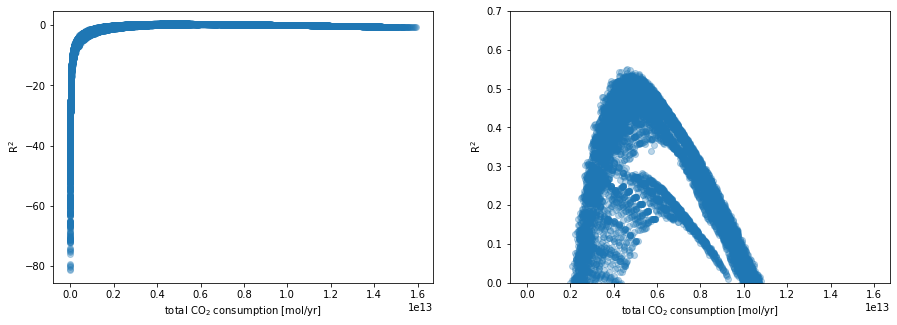

In [16]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(total_CO2_consumption, r2s, alpha=0.3)
ax[1].scatter(total_CO2_consumption, r2s, alpha=0.3)
ax[1].set_ylim(0,0.7)

ax[0].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[0].set_ylabel('R$^{2}$')

ax[1].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[1].set_ylabel('R$^{2}$')

plt.show(fig)

Plot against WSI (weathering saturation index):

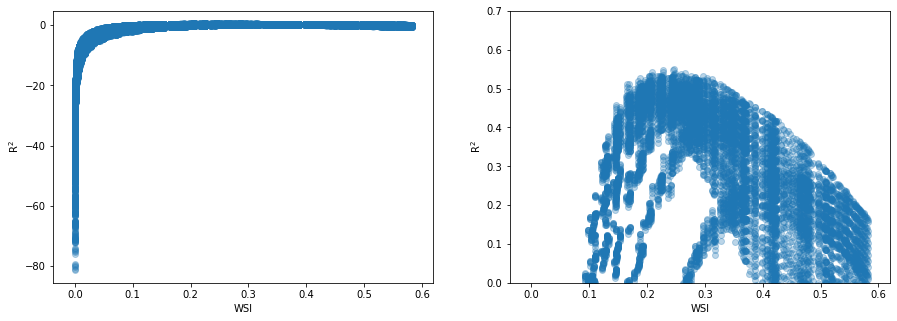

In [17]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(WSI, r2s, alpha=0.3)
ax[1].scatter(WSI, r2s, alpha=0.3)
ax[1].set_ylim(0,.7)

ax[0].set_xlabel('WSI')
ax[0].set_ylabel('R$^{2}$')

ax[1].set_xlabel('WSI')
ax[1].set_ylabel('R$^{2}$')

plt.show(fig)

The best perfoming run:

In [18]:
best_ind = np.argwhere(r2s == np.max(r2s))

best_Kwest = params['Kwest'][best_ind[0][0]]
best_kw = params['kw'][best_ind[0][0]]
best_sigma = params['sigma'][best_ind[0][0]]
best_CaMg_1 = params['CaMg_1'][best_ind[0][0]]
best_CaMg_6 = params['CaMg_6'][best_ind[0][0]]
best_total_CO2_consumption = total_CO2_consumption[best_ind[0][0]]
best_WSI = WSI[best_ind[0][0]]

print('R^2                   = {:.3f}'.format(np.max(r2s)))
print('Kwest                 = {}'.format(best_Kwest))
print('kw                    = {}'.format(best_kw))
print('sigma                 = {}'.format(best_sigma))
print('CaMg_1                = {}'.format(best_CaMg_1))
print('CaMg_6                = {}'.format(best_CaMg_6))
print('total_CO2_consumption = {}'.format(best_total_CO2_consumption))
print('WSI                   = {}'.format(best_WSI))

R^2                   = 0.550
Kwest                 = 4.999999873689376e-05
kw                    = 1.0
sigma                 = 0.0
CaMg_1                = 1500.0
CaMg_6                = 2000.0
total_CO2_consumption = 4611399221248.0
WSI                   = 0.24646858870983124


Filter out the runs that have unreasonable total CO$_{2}$ consumption:

In [19]:
min_thresh_CO2 = 1e12
max_thresh_CO2 = 5e13

drop_inds = np.argwhere((total_CO2_consumption>max_thresh_CO2) & (total_CO2_consumption<min_thresh_CO2)).flatten()

filt_basin_model = basin_model.copy()
filt_basin_model.drop(drop_inds, inplace=True)
filt_basin_model.reset_index(inplace=True, drop=True)

filt_params = params.copy()
filt_params.drop(drop_inds, inplace=True)
filt_params.reset_index(inplace=True, drop=True)

filt_total_CO2_consumption = np.delete(total_CO2_consumption, drop_inds)

filt_WSI = np.delete(WSI, drop_inds)

filt_r2s = np.delete(r2s, drop_inds)

filt_run_ID = np.delete(run_ID, drop_inds)

Filter out the runs that have lower Ca+Mg in metamorphics relative to sediments:

In [20]:
drop_inds = np.argwhere(filt_params['CaMg_1']<=filt_params['CaMg_6']).flatten()

filt_basin_model.drop(drop_inds, inplace=True)
filt_basin_model.reset_index(inplace=True, drop=True)

filt_params.drop(drop_inds, inplace=True)
filt_params.reset_index(inplace=True, drop=True)

filt_total_CO2_consumption = np.delete(filt_total_CO2_consumption, drop_inds)

filt_WSI = np.delete(filt_WSI, drop_inds)

filt_r2s = np.delete(filt_r2s, drop_inds)

filt_run_ID = np.delete(filt_run_ID, drop_inds)

/Users/yuempark/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


After filtering based on total CO$_{2}$ consumption and Ca+Mg, the best perfoming run:

In [21]:
best_ind = np.argwhere(filt_r2s == np.max(filt_r2s))

best_Kwest = filt_params['Kwest'][best_ind[0][0]]
best_kw = filt_params['kw'][best_ind[0][0]]
best_sigma = filt_params['sigma'][best_ind[0][0]]
best_CaMg_1 = filt_params['CaMg_1'][best_ind[0][0]]
best_CaMg_6 = filt_params['CaMg_6'][best_ind[0][0]]
best_total_CO2_consumption = filt_total_CO2_consumption[best_ind[0][0]]
best_WSI = filt_WSI[best_ind[0][0]]

print('R^2                   = {:.3f}'.format(np.max(filt_r2s)))
print('Kwest                 = {}'.format(best_Kwest))
print('kw                    = {}'.format(best_kw))
print('sigma                 = {}'.format(best_sigma))
print('CaMg_1                = {}'.format(best_CaMg_1))
print('CaMg_6                = {}'.format(best_CaMg_6))
print('total_CO2_consumption = {}'.format(best_total_CO2_consumption))
print('WSI                   = {}'.format(best_WSI))

R^2                   = 0.519
Kwest                 = 4.999999873689376e-05
kw                    = 1.0
sigma                 = 0.0
CaMg_1                = 2500.0
CaMg_6                = 2000.0
total_CO2_consumption = 5021457973248.0
WSI                   = 0.24646858870983124


Remove runs that have low R$^{2}$:

In [22]:
drop_inds = np.argwhere(filt_r2s<=0.0).flatten()

best_filt_basin_model = filt_basin_model.copy()
best_filt_basin_model.drop(drop_inds, inplace=True)
best_filt_basin_model.reset_index(inplace=True, drop=True)

best_filt_params = filt_params.copy()
best_filt_params.drop(drop_inds, inplace=True)
best_filt_params.reset_index(inplace=True, drop=True)

best_filt_total_CO2_consumption = np.delete(filt_total_CO2_consumption, drop_inds)

best_filt_WSI = np.delete(filt_WSI, drop_inds)

best_filt_r2s = np.delete(filt_r2s, drop_inds)

best_filt_run_ID = np.delete(filt_run_ID, drop_inds)

In [23]:
print('number of remaining runs = {}'.format(len(best_filt_r2s)))

number of remaining runs = 5883


Make histograms:

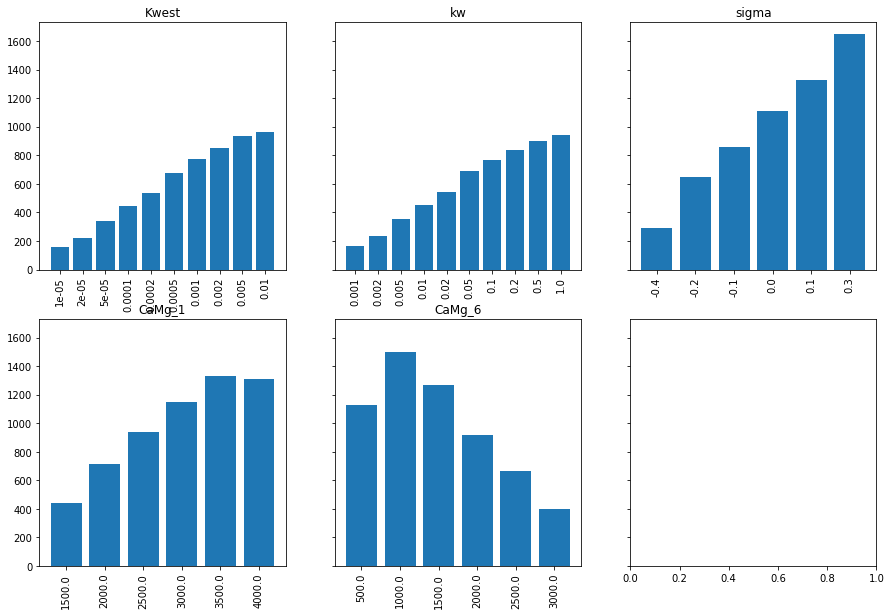

In [24]:
changing_params = ['Kwest','kw','sigma','CaMg_1','CaMg_6']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True)

ax = ax.flatten()

for i in range(len(changing_params)):
    unique_vals = np.array(best_filt_params[changing_params[i]].unique())
    unique_vals = np.sort(unique_vals)
    
    x_index = np.arange(len(unique_vals))
    y_vals = np.zeros(len(unique_vals))
    
    for j in range(len(unique_vals)):
        y_vals[j] = len(best_filt_params[best_filt_params[changing_params[i]]==unique_vals[j]])
    
    ax[i].bar(x_index,y_vals)
    
    ax[i].set_xticks(x_index)
    ax[i].set_xticklabels(np.round(unique_vals,7), rotation=90)
    
    ax[i].set_title(changing_params[i])

plt.show(fig)

## PCA

In [25]:
# get a dataframe with just the changing parameters
stat_cols = ['Kwest','kw','sigma','CaMg_1','CaMg_6']
stat_df = best_filt_params[stat_cols].copy()

# standardize
scaler = StandardScaler()
stat_df = scaler.fit_transform(stat_df)
stat_df = pd.DataFrame(data=stat_df, columns=stat_cols)

# PCA
pca = PCA()
PCA_Y = pca.fit_transform(stat_df)

Make a variety of plots to assess the results of the PCA:

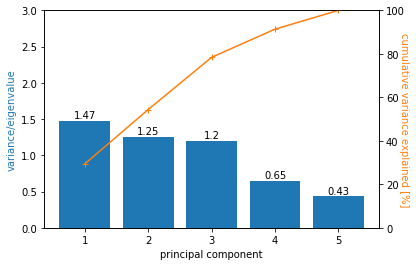

In [26]:
fig, ax = plt.subplots()

rects = ax.bar(np.arange(len(pca.explained_variance_))+1, pca.explained_variance_, color='C0')
ax.set_ylabel('variance/eigenvalue', color='C0')
ax.set_xlabel('principal component')
ax.set_ylim(0,3)

twinax = ax.twinx()
twinax.plot(np.arange(len(pca.explained_variance_ratio_))+1,
            np.cumsum(pca.explained_variance_ratio_)*100, '-+', color='C1')
twinax.set_ylim(0,100)
twinax.set_ylabel('cumulative variance explained [%]', rotation=270, color='C1')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height>=0:
            ax.text(rect.get_x() + rect.get_width()/2, height+0.08,
                    np.round(height,2),
                    ha='center', va='center')
        else:
            ax.text(rect.get_x() + rect.get_width()/2, height-0.08,
                    np.round(height,2),
                    ha='center', va='center')
            
autolabel(rects)

plt.show(fig)

In [27]:
N = len(stat_cols)
for i in range(N):
    print('PC' + str(i+1) + ': ' + str(np.round(pca.explained_variance_ratio_[i]*100,1)) + '%')

PC1: 29.4%
PC2: 25.0%
PC3: 24.0%
PC4: 13.0%
PC5: 8.6%


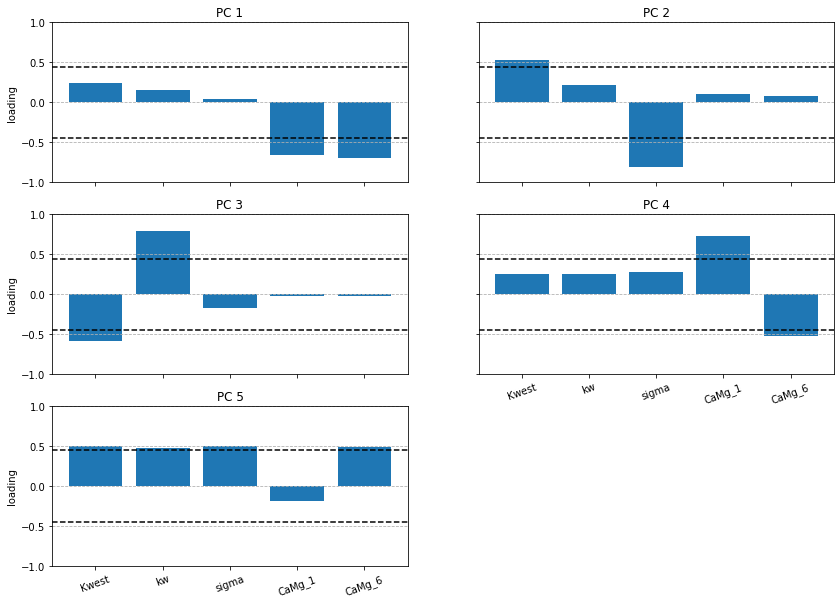

In [28]:
ind = np.arange(N)

component_names = []
for i in range(len(stat_cols)):
    component_names.append('PC ' + str(i+1))

eigenvectors = pd.DataFrame(pca.components_.T, columns=component_names, index=stat_cols)

cutoff = np.sqrt(1/len(stat_cols))

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(14,10), sharey=True)

ax = ax.flatten()

for i in range(N):
    ax[i].bar(ind, eigenvectors['PC ' + str(i+1)], color='C0')
    ax[i].set_ylim(-1,1)
    ax[i].yaxis.grid(ls='--')
    ax[i].axhline(cutoff, ls='--', c='k')
    ax[i].axhline(-cutoff, ls='--', c='k')
    ax[i].set_title('PC ' + str(i+1))
    ax[i].set_xticklabels([])
    
ax[4].set_xticks(ind)
ax[4].set_xticklabels(stat_cols, rotation=20)
ax[3].set_xticks(ind)
ax[3].set_xticklabels(stat_cols, rotation=20)

ax[0].set_ylabel('loading')
ax[2].set_ylabel('loading')
ax[4].set_ylabel('loading')

ax[5].axis('off')

plt.show(fig)

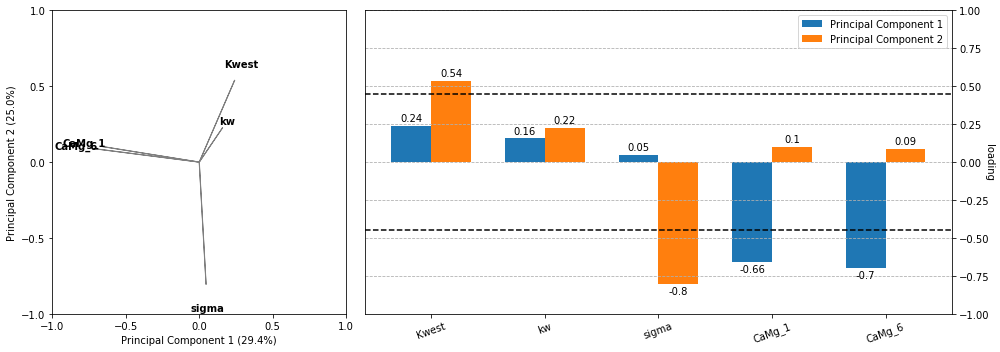

In [29]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14,5), gridspec_kw={'width_ratios':[1,2]})

# loadings plot
x_component = 1
y_component = 2

for i in range(len(stat_cols)):
    ax[0].arrow(0,0,pca.components_[x_component-1,i],pca.components_[y_component-1,i],
                color='C7')
    ax[0].text(pca.components_[x_component-1,i]*1.2,pca.components_[y_component-1,i]*1.2,stat_cols[i],
               ha='center',va='center',fontweight='bold')

ax[0].set_xlim(-1,1)
ax[0].set_xticks([-1,-0.5,0,0.5,1])
ax[0].set_ylim(-1,1)
ax[0].set_yticks([-1,-0.5,0,0.5,1])
ax[0].set_xlabel('Principal Component ' + str(x_component) + ' (' + \
                 str(np.round(pca.explained_variance_ratio_[x_component-1]*100,1)) + '%)')
ax[0].set_ylabel('Principal Component ' + str(y_component) + ' (' + \
                 str(np.round(pca.explained_variance_ratio_[y_component-1]*100,1)) + '%)')

# loadings histogram

width=0.35

rects1 = ax[1].bar(ind, eigenvectors['PC 1'], width, color='C0')
rects2 = ax[1].bar(ind + width, eigenvectors['PC 2'], width, color='C1')

ax[1].set_ylabel('loading', rotation=270)
ax[1].set_xticks(ind + width / 2)
ax[1].set_xticklabels(stat_cols, rotation=20)

ax[1].legend((rects1[0], rects2[0]), ('Principal Component 1', 'Principal Component 2'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height>=0:
            ax[1].text(rect.get_x() + rect.get_width()/2, height+0.05,
                    np.round(height,2),
                    ha='center', va='center')
        else:
            ax[1].text(rect.get_x() + rect.get_width()/2, height-0.05,
                    np.round(height,2),
                    ha='center', va='center')

autolabel(rects1)
autolabel(rects2)

ax[1].set_ylim(-1,1)
ax[1].yaxis.grid(ls='--')
ax[1].axhline(cutoff, ls='--', c='k')
ax[1].axhline(-cutoff, ls='--', c='k')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

fig.tight_layout()

plt.show(fig)

A linear regression of R$^{2}$ to the first 3 principal components:

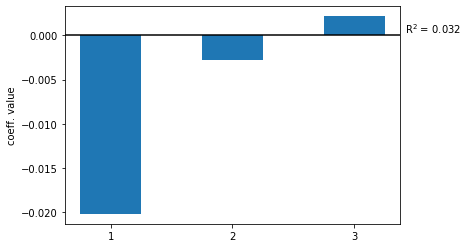

In [30]:
linreg = LinearRegression()
linreg.fit(PCA_Y[:,:3], best_filt_r2s)
score = linreg.score(PCA_Y[:,:3], best_filt_r2s)
coefs = linreg.coef_

fig, ax = plt.subplots()

index = np.arange(len(coefs))
bar_width = 0.5

ax.bar(index, coefs, bar_width)
ax.set_ylabel('coeff. value')
ax.text(1.1, 0.9, 'R$^2$ = {:.3f}'.format(score),
        horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)
ax.axhline(0, c='k')

ax.set_xticks(index)
ax.set_xticklabels(index+1)

plt.show(fig)

A 3D plot of the first 3 principal components:

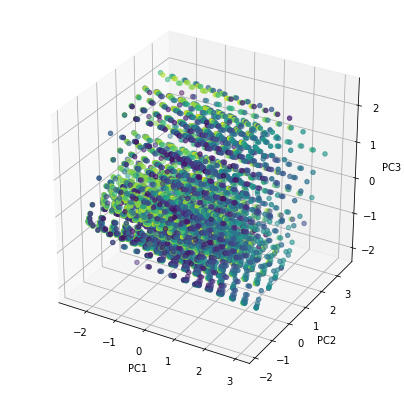

In [31]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA_Y[:,0], PCA_Y[:,1], PCA_Y[:,2], c=best_filt_r2s)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

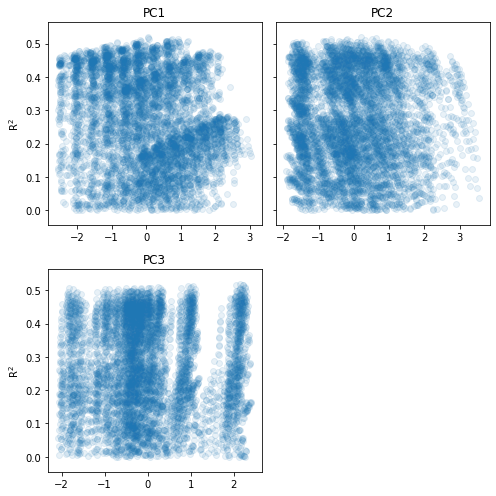

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,7), sharey=True)

ax = ax.flatten()

alpha=0.1

ax[0].scatter(PCA_Y[:,0], best_filt_r2s, alpha=alpha)
ax[0].set_title('PC1')
ax[0].set_ylabel('R$^{2}$')

ax[1].scatter(PCA_Y[:,1], best_filt_r2s, alpha=alpha)
ax[1].set_title('PC2')

ax[2].scatter(PCA_Y[:,2], best_filt_r2s, alpha=alpha)
ax[2].set_title('PC3')
ax[2].set_ylabel('R$^{2}$')

ax[3].axis('off')

fig.tight_layout()
plt.show(fig)

## Parameter Sets For Testing

Make the R$^{2}$ criteria stricter:

In [33]:
drop_inds = np.argwhere(filt_r2s<=0.45).flatten()

best_filt_basin_model = filt_basin_model.copy()
best_filt_basin_model.drop(drop_inds, inplace=True)
best_filt_basin_model.reset_index(inplace=True, drop=True)

best_filt_params = filt_params.copy()
best_filt_params.drop(drop_inds, inplace=True)
best_filt_params.reset_index(inplace=True, drop=True)

best_filt_total_CO2_consumption = np.delete(filt_total_CO2_consumption, drop_inds)

best_filt_WSI = np.delete(filt_WSI, drop_inds)

best_filt_r2s = np.delete(filt_r2s, drop_inds)

best_filt_run_ID = np.delete(filt_run_ID, drop_inds)

In [34]:
print('number of runs remaining = {}'.format(len(best_filt_run_ID)))

number of runs remaining = 606


Get the best perfoming run:

In [35]:
test_run_ID = np.zeros_like(best_filt_run_ID)
test_max_pcc = np.zeros(len(best_filt_run_ID))
test_ind = np.zeros_like(best_filt_run_ID)

best_ind = np.argwhere(best_filt_r2s == np.max(best_filt_r2s))

test_run_ID[0] = best_filt_run_ID[best_ind[0][0]]
test_max_pcc[0] = 0
test_ind[0] = best_ind[0][0]

Get the run that has the smallest maximum Pearson correlation coefficient with all preceding selected test runs:

In [36]:
# correlation matrix
pcc_matrix = np.corrcoef(basin_model.loc[best_filt_run_ID])

for i in range(1,len(best_filt_run_ID)):
    # get the indices of runs we have already selected
    current_test_ind = test_ind[:i]
    
    # get the pcc matrix for those runs
    current_pcc_matrix = pcc_matrix[current_test_ind, :]
    
    # get the max pcc for each run
    current_pcc_max = np.max(current_pcc_matrix, axis=0)
    
    # get the index of the run with the smallest maximum pcc
    min_pcc_ind = np.argwhere(current_pcc_max == np.min(np.delete(current_pcc_max, current_test_ind)))[0][0]
    
    # store
    test_ind[i] = min_pcc_ind
    test_max_pcc[i] = current_pcc_max[min_pcc_ind]
    test_run_ID[i] = best_filt_run_ID[min_pcc_ind]

Plot results:

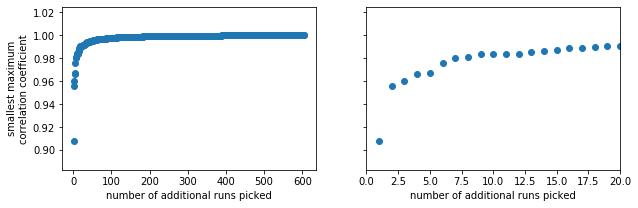

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3), sharey=True)

ax[0].scatter(np.arange(1,len(test_max_pcc)), test_max_pcc[1:])
ax[0].set_xlabel('number of additional runs picked')
ax[0].set_ylabel('smallest maximum\ncorrelation coefficient')

ax[1].scatter(np.arange(1,len(test_max_pcc)), test_max_pcc[1:])
ax[1].set_xlabel('number of additional runs picked')
ax[1].set_xlim(0,20)

plt.show(fig)

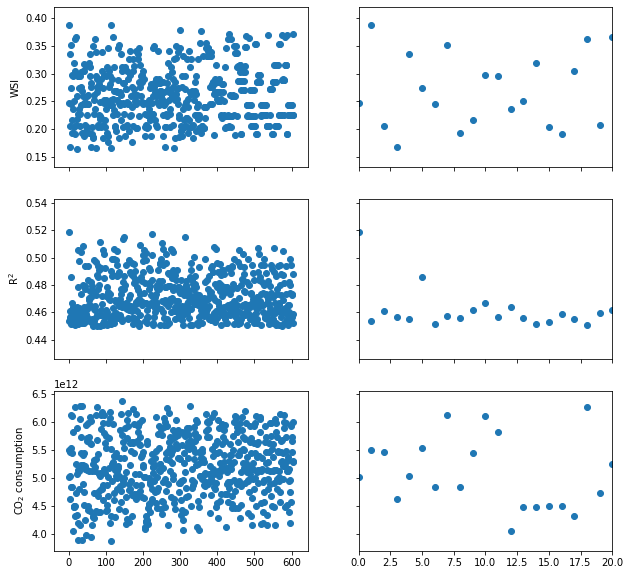

In [38]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex='col', sharey='row', figsize=(10,10))

ax = ax.flatten()

ax[0].scatter(np.arange(len(test_max_pcc)), WSI[test_run_ID])
ax[0].set_ylabel('WSI')

ax[1].scatter(np.arange(len(test_max_pcc)), WSI[test_run_ID])
ax[1].set_xlim(0,20)

ax[2].scatter(np.arange(len(test_max_pcc)), r2s[test_run_ID])
ax[2].set_ylabel('R$^{2}$')

ax[3].scatter(np.arange(len(test_max_pcc)), r2s[test_run_ID])
ax[3].set_xlim(0,20)

ax[4].scatter(np.arange(len(test_max_pcc)), total_CO2_consumption[test_run_ID])
ax[4].set_ylabel('CO$_{2}$ consumption')

ax[5].scatter(np.arange(len(test_max_pcc)), total_CO2_consumption[test_run_ID])
ax[5].set_xlim(0,20)

plt.show(fig)

Take the first 10:

In [39]:
test_Kwest = params['Kwest'][test_run_ID[:10]]
test_kw = params['kw'][test_run_ID[:10]]
test_sigma = params['sigma'][test_run_ID[:10]]
test_CaMg_1 = params['CaMg_1'][test_run_ID[:10]]
test_CaMg_6 = params['CaMg_6'][test_run_ID[:10]]
test_total_CO2_consumption = total_CO2_consumption[test_run_ID[:10]]
test_WSI = WSI[test_run_ID[:10]]
test_r2s = r2s[test_run_ID[:10]]

test_df = pd.DataFrame({'run_ID':test_run_ID[:10],
                        'Kwest':test_Kwest,
                        'kw':test_kw,
                        'sigma':test_sigma,
                        'CaMg_1':test_CaMg_1,
                        'CaMg_6':test_CaMg_6,
                        'CO2_cons':test_total_CO2_consumption,
                        'WSI':test_WSI,
                        'r2':test_r2s})
test_df.reset_index(drop=True, inplace=True)
test_df.to_csv('test_params.csv')
test_df

,run_ID,Kwest,kw,sigma,CaMg_1,CaMg_6,CO2_cons,WSI,r2
0,13947,0.00005,1.000,0.0,2500.0,2000.0,5.021458e+12,0.246469,0.518690
1,6373,0.00050,1.000,-0.1,1500.0,1000.0,5.501154e+12,0.387279,0.453972
2,9965,0.01000,0.005,-0.1,3500.0,3000.0,5.467925e+12,0.206113,0.460947
3,12887,0.00002,1.000,0.0,4000.0,3000.0,4.628216e+12,0.168097,0.456948
4,11851,0.00001,1.000,0.3,2000.0,1000.0,5.038316e+12,0.334458,0.455204
5,8619,0.00200,1.000,-0.4,2500.0,2000.0,5.540126e+12,0.273956,0.485506
6,12914,0.00002,1.000,0.1,3500.0,1500.0,4.839891e+12,0.245007,0.451586
7,12824,0.00002,0.500,0.3,2000.0,1500.0,6.115813e+12,0.351124,0.457162
8,7558,0.00100,1.000,-0.4,4000.0,2500.0,4.833481e+12,0.193774,0.455793
9,13786,0.00005,0.200,0.1,4000.0,2500.0,5.442155e+12,0.216411,0.461778


Make cross plots for each of these 10 runs:

/Users/yuempark/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


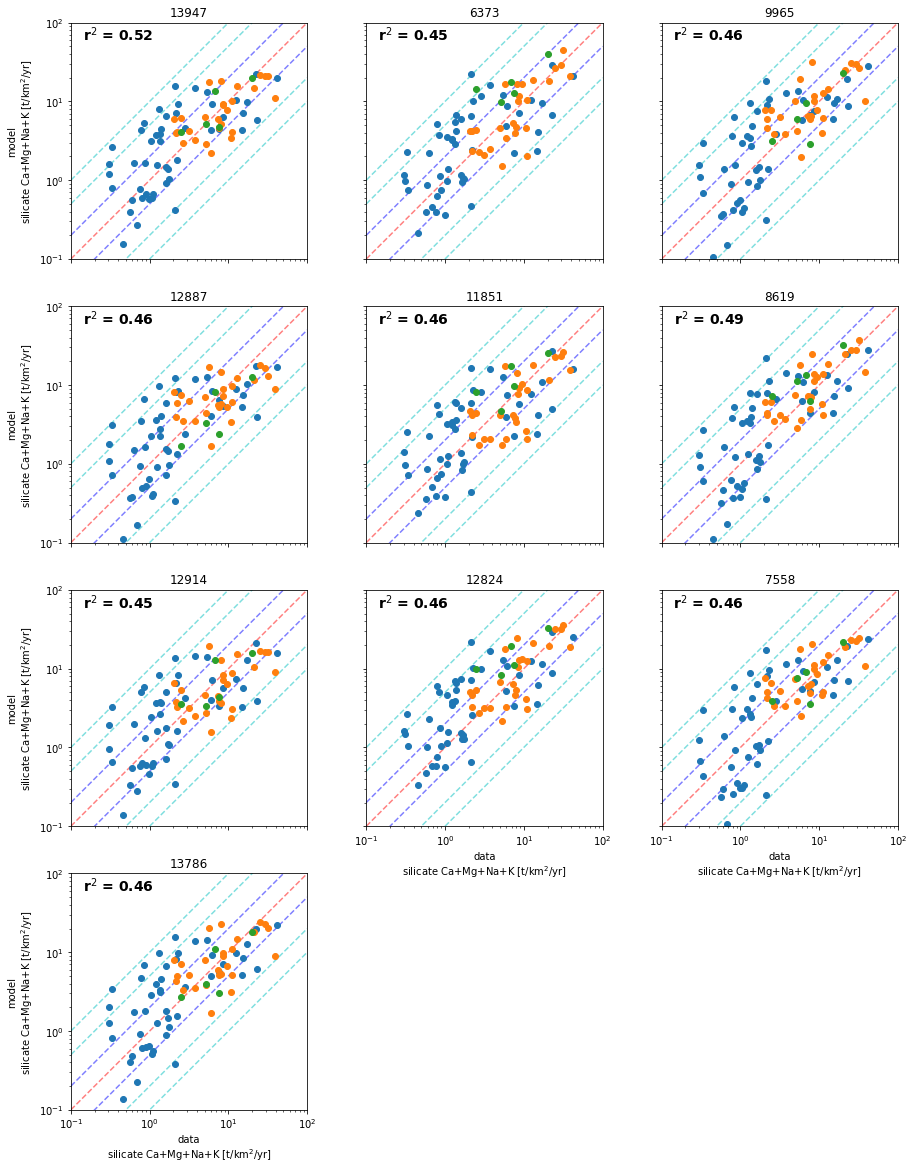

In [40]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,20), sharey=True)

ax = ax.flatten()

for i in range(len(test_df)):
    log_cross_plot(basin_model.loc[test_df['run_ID'][i]],
                   basin_data['CaMgNaK_sil_norm'],
                   basin_data['source'],
                   test_df['r2'][i],
                   ax[i],
                   legend=False, labels=False)
    ax[i].set_title(test_df['run_ID'][i])
    
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels([])
ax[3].set_xticklabels([])
ax[4].set_xticklabels([])
ax[5].set_xticklabels([])
ax[6].set_xticklabels([])

ax[7].set_xlabel('data\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax[8].set_xlabel('data\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax[9].set_xlabel('data\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')

ax[0].set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax[3].set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax[6].set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax[9].set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
    
ax[10].axis('off')
ax[11].axis('off')
    
plt.show(fig)

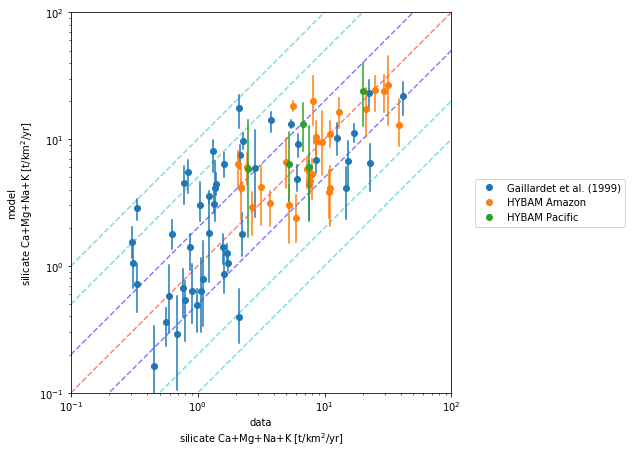

In [41]:
fig, ax = plt.subplots(figsize=(7,7))

unique_sources = ['Gaillardet et al. (1999)',
                  'HYBAM Amazon',
                  'HYBAM Pacific']

# Ca + Mg + Na + K
xlim = np.array([1e-1, 1e2])
ylim = np.array([1e-1, 1e2])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.plot(xlim, ylim, c='r', ls='--', zorder=-99, alpha=0.5)
ax.plot(xlim, ylim*2, c='b', ls='--', zorder=-99, alpha=0.5)
ax.plot(xlim, ylim*(1/2), c='b', ls='--', zorder=-99, alpha=0.5)
ax.plot(xlim, ylim*5, c='c', ls='--', zorder=-99, alpha=0.5)
ax.plot(xlim, ylim*(1/5), c='c', ls='--', zorder=-99, alpha=0.5)
ax.plot(xlim, ylim*10, c='c', ls='--', zorder=-99, alpha=0.5)
ax.plot(xlim, ylim*(1/10), c='c', ls='--', zorder=-99, alpha=0.5)

run_mean = np.mean(basin_model.loc[test_df['run_ID']], axis=0)
run_max = np.max(basin_model.loc[test_df['run_ID']], axis=0)
run_min = np.min(basin_model.loc[test_df['run_ID']], axis=0)

for i in range(len(unique_sources)):
    source_inds = np.argwhere(basin_data['source']==unique_sources[i])
    source_inds = source_inds.flatten()
    
    for j in range(len(source_inds)):
        ax.plot(np.ones(2)*basin_data['CaMgNaK_sil_norm'][source_inds[j]],
                [run_min[source_inds[j]], run_max[source_inds[j]]],
                c='C'+str(i))
    
    ax.plot(basin_data['CaMgNaK_sil_norm'][source_inds],
            run_mean[source_inds],
            'o', c='C'+str(i), label=unique_sources[i])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel('data\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')
ax.set_ylabel('model\nsilicate Ca+Mg+Na+K [t/km$^{2}$/yr]')

ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.show(fig)